<a href="https://colab.research.google.com/github/aiyer31/TensorFlow-Tutorials/blob/master/CNN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Aiming to try to write by own basic CNN to predict images in the MNIST dataset.

This is based off of Pedersen's TF tutorials. Also at my github.
https://github.com/aiyer31/TensorFlow-Tutorials

## Architecture

Each image is 28x28. 

Layer 1: Convolution of 5x5. Using 5x5 because the intuition is that a tapering kernel size will capture the general features followed by specific features. **Is this true?** We can use 16 of these filters so that we end up with a set of 16 feature maps. Zero pad the 28x28 image (SAME convolution). We'll go with the "same" convolution technique rather than a full/valid convolution. To pool these images, we can use a 2x2 max pooling. Each of the feature maps will then become size 14x14.

Layer 2: Another convolutional layer wherein, we use 32 3x3 filters and pad accordingly. 2x2 max pooling further reduces the size of each feature map to 7x7. 

Side note: When the filter size decreases we are using more feature maps/channels.

Layer 3: Flatten the layer and feed into a fully connected layer. The size of the input to the layer based on the above numbers is going to be:
num_feature maps*(input_image_size/pooling_filter_size) = 32 * (14 * 14 / 2 * 2) = 32 * 7 * 7 = 1568

The number of hidden units in the FC layer can be 128.

Layer 4: Softmax layer with 10 classes for prediction


Results:

Note: The column conv filters is:
Conv Layer 1 Filter Size, Conv Layer 1 Number of Channels, Conv Layer 2 Filter Size, Conv Layer 2 Number of Channels

| Weights Initialization | Biases Initialization | Conv Filters | Learning Rate | FC Layer Length | Batch Size | Accuracy after 10k iterations (%) |
|------------------------|-----------------------| ------------ | ------------- | --------------- | ----------- | ------   |
| All Zeros              | All Zeros             | 5, 16, 5, 36 | 0.0001 | 128 | 64 | 11.3|
| All Zeros              | Constant of 0.05      | 5, 16, 5, 36 | 0.0001 | 128 | 64 | 11.3|
| Normal with stddev=0.05 | All Zeros | 5, 16, 5, 36 | 0.0001 | 128 | 64 | 98.5 | 
| Normal with stddev=0.05 | Constant of 0.05 | 5, 16, 5, 36 | 0.0001 | 128 | 64 | 98.7|
| Normal with stddev=0.05 | Constant of 0.05 | 5, 16, 5, 36 | 0.0001 | 256 | 64 | 98.7|
| Normal with stddev=0.05 | Constant of 0.05 | 5, 16, 5, 36 | 0.0001 | 64 | 64 | 98.6|



### Imports




In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

In [ ]:
# Use TensorFlow v.2 with this old v.1 code.
# E.g. placeholder variables and sessions have changed in TF2.
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [ ]:
tf.__version__

'2.4.0'

## Load Data

In [ ]:
# Clone the repository from GitHub to Google Colab's temporary drive.
import os
work_dir = "/content/TensorFlow-Tutorials/"
if not os.path.exists(work_dir):
    !git clone https://github.com/Hvass-Labs/TensorFlow-Tutorials.git
os.chdir(work_dir)

In [ ]:
from mnist import MNIST
data = MNIST(data_dir="data/MNIST/")

# The number of pixels in each dimension of an image.
img_dim = data.img_size

# The images are stored in one-dimensional arrays of this length.
img_size_flat = data.img_size_flat

# Tuple with height and width of images used to reshape arrays.
img_shape = data.img_shape

# Number of classes, one class for each of 10 digits.
num_classes = data.num_classes

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = data.num_channels
data.num_train, data.num_test, img_dim, img_size_flat, img_shape, num_classes, num_channels

(55000, 10000, 28, 784, (28, 28), 10, 1)

In [ ]:
# Convert the raw data into TF tensors

# We define placeholders for inputs so that for every iteration of training this placeholder changes value. This is why we can't use tf.constant to feed our inputs into tensorflow.
input = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='input')

# The convolutional layers expect x to be a 4 dimensional tensor -> (batch size, image_height, image_width, num_input_channels)
# In our example, image_height = image_width, batch_size is inferred so we pass -1 and num_input_channels is defined by num_channels above.
input_image = tf.reshape(input, shape=[-1, img_dim, img_dim, num_channels])

# As for the output label we have:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name="y_true")

y_true_class = tf.argmax(y_true, axis=1)

## Plotting function

## Helper functions



In [ ]:
def get_weights(layer_name, layer_shape):
  # return tf.Variable(tf.constant(0.0, shape=layer_shape))
  return tf.Variable(tf.truncated_normal(layer_shape, stddev=0.05))

def get_biases(layer_name, layer_length):
  # return tf.Variable(tf.constant(0.0, shape=[layer_length]))
  return tf.Variable(tf.constant(0.05, shape=[layer_length]))


### Helper function that creates a fully connected layer


In [ ]:
# This function instantiates a fully connected layer of size 
# *layer_size* with input *input*. The activation function used is passed via a string, defaulting to RELU.
# The function also takes in "input_name" which is a string to denote the weights and biases of for the FC layer.

_RELU = "relu"
_SOFTMAX = "softmax"
def activation_function(activation_str: str, input_tensor):
  if activation_str == _RELU:
      return tf.nn.relu(input_tensor)
  if activation_str == _SOFTMAX:
      return tf.nn.softmax(input_tensor)
  return input_tensor # no activation

def fc_layer(input_name, input, input_size, layer_size, activation_str = _RELU):
  weights = get_weights(input_name, layer_shape=[input_size, layer_size])
  biases = get_biases(input_name, layer_length=layer_size)

  return activation_function(activation_str, tf.matmul(input, weights) + biases)
  

## Helper function that creates a convolutional layer

In [ ]:
# The convolutional layer takes in:
# 1. Input
# 2. Number of input feature maps
# 3. Number of kernel filters
# 4. Kernel width (Assuming only square filters)

def convolutional_layer(layer_name, input, num_input_feature_maps, kernel_width, num_kernels):
  kernel_weights = get_weights(layer_name, layer_shape=[kernel_width, kernel_width, num_input_feature_maps, num_kernels])
  kernel_biases = get_biases(layer_name, layer_length=num_kernels)

  # Now that we've initialized the kernels, we need to convolve the kernel with the input
  # We can use the tf.nn.conv2d function. The filters argument needs to be of size [filter_width, filter_width, num_in_channels, num_out_channels]
  convolved_image = tf.nn.conv2d(input=input, filters=kernel_weights, strides=[1, 1, 1, 1], padding='SAME')

  convolved_image += kernel_biases

  # Now that we've convolved the image we need to decide how we would like to pool.
  # For now let us use 2x2 max-pooling
  # TODO: make pooling optional, and pooling arguments optional to this function.
  pooled_image = tf.nn.max_pool(value=convolved_image, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

  # Apply activation on the pooled image
  # NOTE: Usually activations happen before pooling but max_pool and RELU are commutative anyway
  return tf.nn.relu(pooled_image)

## Helpful Constants

In [ ]:
conv_1_filter_size = 5
conv_1_num_filters = 16

conv_2_filter_size = 5 # originally was 3
conv_2_num_filters = 36 # originally was 32

fc_layer_size = 64

batch_size = 64

## Layer 1: The convolutional layer using 16 5x5 filters

In [ ]:
layer_1 = convolutional_layer(layer_name="convolution_1", 
                              input=input_image, 
                              num_input_feature_maps=num_channels,
                              kernel_width=conv_1_filter_size,
                              num_kernels=conv_1_num_filters
                              )

In [ ]:
# Checking the size of layer_1
layer_1

<tf.Tensor 'Relu_15:0' shape=(?, 14, 14, 16) dtype=float32>

## Layer 2: Convolutional layer using 32 3x3 filters

In [ ]:
layer_2 = convolutional_layer(layer_name="convolution_2", 
                              input=layer_1, 
                              num_input_feature_maps=conv_1_num_filters,
                              kernel_width=conv_2_filter_size,
                              num_kernels=conv_2_num_filters
                              )

In [ ]:
layer_2

<tf.Tensor 'Relu_16:0' shape=(?, 7, 7, 36) dtype=float32>

## Flatten the input to prepare for the fully connected layer

In [ ]:
layer_shape = layer_2.get_shape()
layer_shape

TensorShape([Dimension(None), Dimension(7), Dimension(7), Dimension(36)])

In [ ]:
layer_shape[0:4]

TensorShape([Dimension(None), Dimension(7), Dimension(7), Dimension(36)])

In [ ]:
layer_shape[1:4]

TensorShape([Dimension(7), Dimension(7), Dimension(36)])

In [ ]:
layer_shape[1:4].num_elements()

1764

In [ ]:
num_features = layer_2.get_shape()[1:4].num_elements() # The shape is assumed to be a 4 dimensional tensor looking like (batch_size, img_height, img_width, num_channels)
flattened_layer = tf.reshape(layer_2, shape=[-1, num_features])
flattened_layer

<tf.Tensor 'Reshape_11:0' shape=(?, 1764) dtype=float32>

## Layer 3: Fully connected Layer with 128 hidden units

In [ ]:
fully_connected_layer = fc_layer(input_name="dense_layer", input=flattened_layer, input_size=num_features, layer_size=fc_layer_size)
fully_connected_layer

<tf.Tensor 'Relu_17:0' shape=(?, 64) dtype=float32>

In [ ]:
final_prediction_layer = fc_layer(input_name="prediction_layer", input=fully_connected_layer, input_size=fc_layer_size, layer_size=num_classes, activation_str=None)

In [ ]:
final_prediction_layer

<tf.Tensor 'add_23:0' shape=(?, 10) dtype=float32>

## Predict the class by taking the argmax of the softmax over the above layer

In [ ]:
y_pred = tf.nn.softmax(final_prediction_layer)
y_pred_class = tf.argmax(y_pred, axis=1)


## Define the loss function for this network. 

In [ ]:
# We'll be using the softmax cross entropy loss (just like binary cross entropy/log loss but with multiple classes)

cross_entropy_loss = tf.nn.softmax_cross_entropy_with_logits(logits=final_prediction_layer,
                                                             labels=y_true) # Apparently the softmax function calculates the softmax internally, so we must use the predictions PRE-softmax application.

cost = tf.reduce_mean(cross_entropy_loss)

## Define the optimization method

In [ ]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)

## Performance Measures

In [ ]:
# We'll just use accuracy for now. Might be worthwhile to understand if there's any data skew in the above dataset.
correct_prediction = tf.equal(y_pred_class, y_true_class)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Setting TF up to run

In [ ]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [ ]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch, _ = data.random_batch(batch_size=batch_size)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {input: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

### Function to plot example errors:


In [ ]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.x_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.y_test_cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### Function to plot confusion matrix

In [ ]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.y_test_cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Function to print accuracy

In [ ]:
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = data.num_test

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.x_test[i:j, :]

        # Get the associated labels.
        labels = data.y_test[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {input: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_class, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = data.y_test_cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

### Accuracy before training:


In [ ]:
print_test_accuracy()

Accuracy on Test-Set: 9.8% (979 / 10000)


### Accuracy After One Iteration

In [ ]:
optimize(num_iterations=1)

Optimization Iteration:      1, Training Accuracy:   7.8%
Time usage: 0:00:00


In [ ]:
print_test_accuracy()

Accuracy on Test-Set: 9.8% (980 / 10000)


### Accuracy After 100 optimization iterations

In [ ]:
optimize(num_iterations=99)

Time usage: 0:00:06


In [ ]:
print_test_accuracy()

Accuracy on Test-Set: 49.8% (4982 / 10000)


### Accuracy after 1000 iterations

In [ ]:
optimize(num_iterations=900)

Optimization Iteration:    101, Training Accuracy:  48.4%
Optimization Iteration:    201, Training Accuracy:  85.9%
Optimization Iteration:    301, Training Accuracy:  89.1%
Optimization Iteration:    401, Training Accuracy:  87.5%
Optimization Iteration:    501, Training Accuracy:  89.1%
Optimization Iteration:    601, Training Accuracy:  87.5%
Optimization Iteration:    701, Training Accuracy:  93.8%
Optimization Iteration:    801, Training Accuracy:  92.2%
Optimization Iteration:    901, Training Accuracy:  93.8%
Time usage: 0:00:57


In [ ]:
print_test_accuracy()

Accuracy on Test-Set: 92.0% (9197 / 10000)


### Performance after 10000 iterations

In [ ]:
optimize(num_iterations=9000)

Optimization Iteration:   1001, Training Accuracy:  89.1%
Optimization Iteration:   1101, Training Accuracy:  92.2%
Optimization Iteration:   1201, Training Accuracy:  92.2%
Optimization Iteration:   1301, Training Accuracy:  87.5%
Optimization Iteration:   1401, Training Accuracy:  90.6%
Optimization Iteration:   1501, Training Accuracy:  93.8%
Optimization Iteration:   1601, Training Accuracy:  93.8%
Optimization Iteration:   1701, Training Accuracy:  95.3%
Optimization Iteration:   1801, Training Accuracy:  90.6%
Optimization Iteration:   1901, Training Accuracy:  96.9%
Optimization Iteration:   2001, Training Accuracy:  93.8%
Optimization Iteration:   2101, Training Accuracy:  93.8%
Optimization Iteration:   2201, Training Accuracy:  93.8%
Optimization Iteration:   2301, Training Accuracy:  96.9%
Optimization Iteration:   2401, Training Accuracy:  95.3%
Optimization Iteration:   2501, Training Accuracy:  92.2%
Optimization Iteration:   2601, Training Accuracy:  92.2%
Optimization I

In [ ]:
print_test_accuracy()

Accuracy on Test-Set: 98.6% (9856 / 10000)


Accuracy on Test-Set: 98.6% (9856 / 10000)
Example errors:


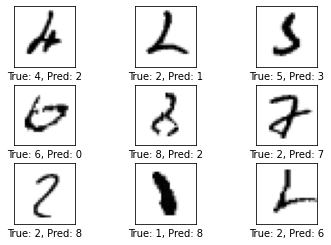

Confusion Matrix:
[[ 972    0    1    0    0    0    3    1    3    0]
 [   0 1127    3    0    0    0    2    0    3    0]
 [   2    5 1008    1    1    0    2    3   10    0]
 [   1    0    1  997    0    5    0    2    3    1]
 [   0    0    1    0  978    0    0    0    1    2]
 [   1    0    0    4    0  884    3    0    0    0]
 [   2    2    0    1    2    4  946    0    1    0]
 [   0    1    7    3    0    0    0 1005    2   10]
 [   3    0    2    2    3    4    1    2  953    4]
 [   2    5    0    2    7    4    0    2    1  986]]


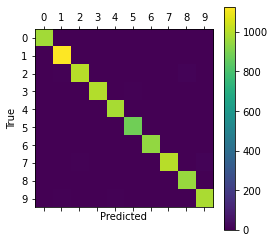

In [ ]:
print_test_accuracy(show_example_errors=True, show_confusion_matrix=True)